## 02. Using the GALACTICNUCLEUS catalog

This script aims to simulate a spectral image that would be observed using slitless spectroscopy, using the data on the star position and flux as was obtained from the GALACTICNUCLEUS survey. The original publication can be found [here](https://www.aanda.org/articles/aa/full_html/2019/11/aa36263-19/aa36263-19.html#S2) and the data can also be downloaded from [here](http://cdsarc.unistra.fr/viz-bin/cat/J/A+A/631/A20). 

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Francisco Nogueras-Lara and Nadine Neumayer (MPIA)** <br/>
Date: **05th October 2020** <br/>

In [1]:
import astropy.units as u
import astropy.io.fits as fits

from scipy.sparse import csr_matrix, csc_matrix
import scipy.stats as stats
from scipy.interpolate import interp1d
import numpy as np
import os
import importlib
import math  

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

# to show progress during computations
import time
import sys

# for generating permutations of star configurations
from sympy.utilities.iterables import multiset_permutations
from sympy import factorial

In [2]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

**Personal imports** (functions imported can be found in the 'imported_files/' folder)

In [3]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt
import Slitless_spec_forward_modelling as ssfm
import fleasibility as fl

#### 1. Defining input parameters

In [4]:
# setting up the working directory path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Data")

# putting together the file name
string_name = 'central_pixels.txt'
filename = os.path.join(data_dir, string_name)

# FOV in pixels
l_pix, u_pix = 0, 1128

# cuts off faint stars with mag > cut_off_ll
cut_off_ll = 15

# set the dispersion range of the spectra
disperse_range = ss.defineDispersionRange(r=4000, lambda0=2.2, band_width=0.4)
print('The size of dispersion is set to be %d pixels'%disperse_range)

dispersion_angle = 0 # degrees

# pixel scale factor (arcseconds/pxiel)
pixel_scale_EMIR = 0.193 
pixel_scale_HAWK_I = 0.053
pixel_factor = pixel_scale_EMIR/pixel_scale_HAWK_I

# start pixels of a small region of the sky
x_start, y_start = 1000, 2500
limits = ssfm.generateLimits(x_start, y_start, [u_pix+disperse_range, u_pix])
u_pix_arr = [int(u_pix+disperse_range), u_pix]

# PSF parameters
sigma_PSF = 10
factor_widen_PSF = int(disperse_range/3)
norm_PSF = 30

The size of dispersion is set to be 727 pixels


Star distribution parameters

In [5]:
# Load the 10 random spectra with added LSF, which can be associated with the stars in the FOV.
flux_LSF2D, params = np.load('Data/flux_K2D_LSF_norm.npy'), np.load('Data/params.npy')
waves_k = np.load('Data/waves_k.npy')

# division of stars chosen in FOV, considering 10 temperatures with 10 log g's
stars_divide = ssfm.decideNumHotStars(hot_stars=0.1)

# selection cut to select forground star
forground_star_cut = 1.1

# hot star percents used later in the notebook while conducting fleasibility studies
hot_stars_arr = np.arange(1, 100, 10)/100

Reading the central catalogue file

In [6]:
x_pos_full, y_pos_full, mag_H_full, mag_Ks_full = ssfm.readCatalogFile(filename, pixel_factor)

#### 2. Selection Procedure

1. Select small region of the sky for the given FOV
2. Select stars whose flux != 99 (implying no star exists in the data set)
3. Select stars whose flux is magnitude is > 50

In [7]:
# step 1: defining the FOV to be a few arcmin x arcmin
x_pos, y_pos, mag_H, mag_Ks = ssfm.selectFOV(limits, x_pos_full, y_pos_full, mag_H_full, mag_Ks_full)

# step 2: make sure data is free of rogue points i.e. flux = 99 points
x_pos, y_pos, mag_H, mag_Ks = ssfm.selectRealStars(x_pos, y_pos, mag_H, mag_Ks)

# step 3: setting lower limit on the flux
x_pos, y_pos, mag_H, mag_Ks = ssfm.cutOffFlux(cut_off_ll, x_pos, y_pos, mag_H, mag_Ks)

print('Total number of stars in %d x %d pixels: %d'%(u_pix_arr[0], u_pix_arr[1], len(mag_Ks)))
np.save('Data/selected_FOV_og.npy', [x_pos, y_pos, mag_H, mag_Ks])

Choosing 84476 stars from 2009522 total stars.
Selecting real stars...
Discarding stars with magnitude > 15.
Total number of stars in 1855 x 1128 pixels: 9472


Plotting the selected stars in the chosen FOV.

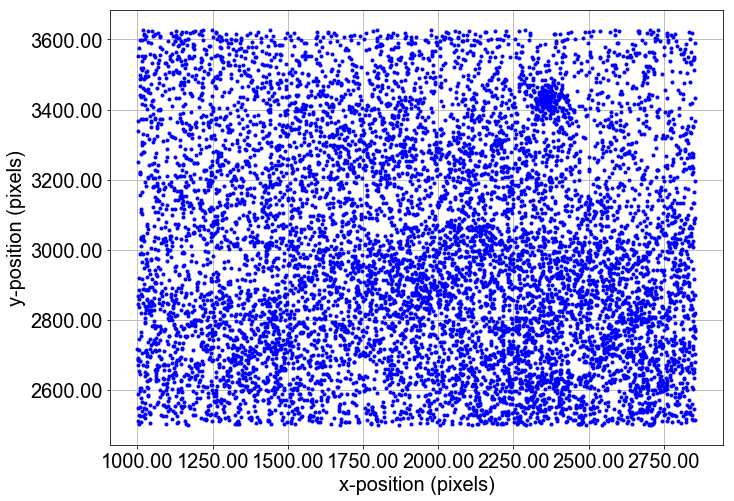

In [8]:
fig, ax = plt.subplots(1,1,figsize=(11,8))

# plotting the stars
ax.plot(x_pos, y_pos, "b.")
pt.setLabel(ax, 'x-position (pixels)', 'y-position (pixels)', '', 'default', 'default', legend=False)

pt.shortenXYaxisTicks(ax)

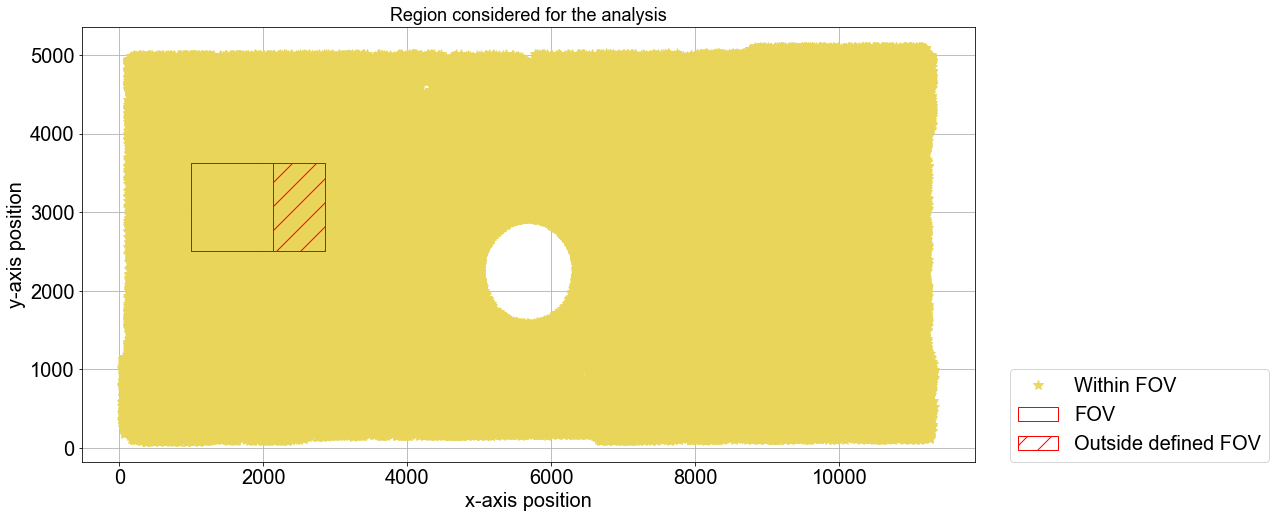

In [9]:
total_stars_FOV_params = [x_pos, y_pos, mag_H, mag_Ks]
selected_c_pxls = np.load('Data/selected_central_pixels.npy')
pt.showTheRegionOfAnalysis(selected_c_pxls, total_stars_FOV_params, x_start, y_start, u_pix)

#### 3. Dispersing the stars

In [10]:
# mapping right ascension and declination to (pixel, pixel) FOV
x_pos, y_pos = ssfm.mapToFOVinPixels(x_pos, y_pos, u_pix_arr)

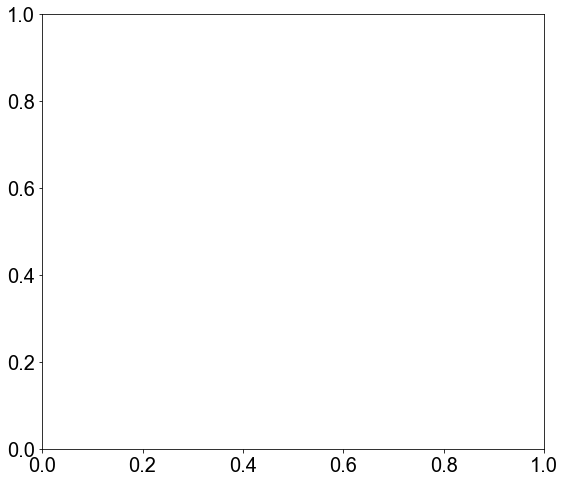

In [60]:
# dispersing the stars and plotting it
fig, ax = plt.subplots(1,1,figsize=(9,8))
x_disperse, y_disperse = pt.plotDispersedStars(ax, x_pos, y_pos, disperse_range, \
                                               waves_k, dispersion_angle, no_plot=False)

In [33]:
np.save('Data/selected_FOV.npy', [x_pos, y_pos, mag_H, mag_Ks])

Associates the stars with spectra of a certain temperature, log(surface gravity) at redshift, z=0. 

In [11]:
flux_k2D, type_id = ssfm.associateSpectraToStars(waves_k, stars_divide, len(mag_Ks), \
                                  flux_LSF2D, params, print_msg=True)
np.save('Data/Many_star_model/type_ids_selected_FoV.npy', type_id)

# multiplying the normalized flux my the flux of the star 
flux_k2D = [flux_k2D[i]*(10**(7-0.4*mag_Ks[i])) for i in range(len(mag_Ks))]

947 stars at Teff = 12000 K, log g = 6.0
0 stars at Teff = 11800 K, log g = 2.5
0 stars at Teff = 10000 K, log g = 3.0
0 stars at Teff = 8400 K, log g = 6.0
0 stars at Teff = 7600 K, log g = 3.5
0 stars at Teff = 6900 K, log g = 3.0
0 stars at Teff = 5900 K, log g = 3.0
8525 stars at Teff = 5100 K, log g = 2.0
0 stars at Teff = 4700 K, log g = 1.5
0 stars at Teff = 3900 K, log g = 6.0
---------------------------------



Shuffle the produced flux array and hence, the corresponding stellar types.

In [15]:
flux_k2D_shuffled, type_id_shuffled = ssfm.shuffleAlongAxis(np.array(flux_k2D), np.array(type_id))
np.save('Data/Many_star_model/type_id_shuffled.npy', type_id_shuffled)

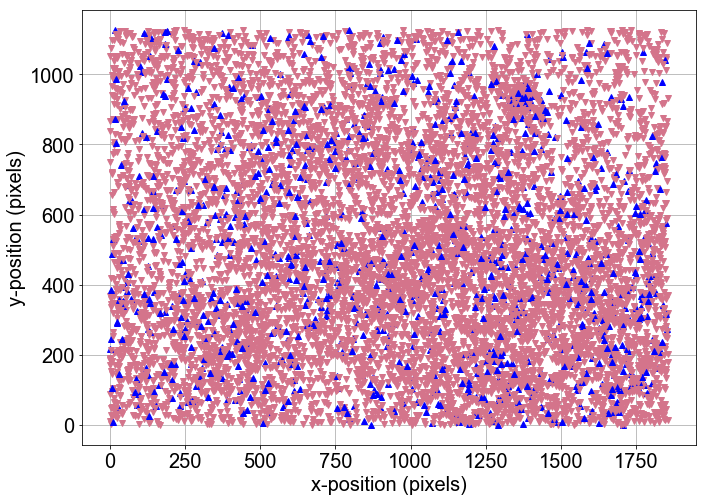

In [14]:
fig, ax = plt.subplots(1,1, figsize=(11, 8))
color_arr = []
for i in range(len(type_id_shuffled)):
    if type_id_shuffled[i] == 0:
        color = 'b'
        marker = "^"
    if type_id_shuffled[i] == 7:
        color = '#d4748b'
        marker = "v"
    ax.plot(x_pos[i], y_pos[i], color=color, marker=marker)
pt.setLabel(ax, 'x-position (pixels)', 'y-position (pixels)', '', 'default', 'default', legend=False)


In [122]:
# defining the matricies
flux_matrix2D = np.zeros((u_pix_arr[1], u_pix_arr[0]))

# construct the 2D flux image with LSF added
flux_matrix2D = ss.construct2DFluxMatrix(flux_matrix2D, y_disperse, x_disperse, \
                                         flux_k2D_shuffled, u_pix_arr)

Add the PSF

In [ ]:
flux_PSF3D, y_dispersePSF = ss.addPSF(y_pos, y_disperse, sigma_PSF, disperse_range, \
                                      factor_widen=factor_widen_PSF, norm=norm_PSF)

flux_PSF_matrix2D = ss.constructFluxMatrixPSF(x_pos, x_disperse, y_dispersePSF, \
                                              flux_PSF3D, u_pix_arr)

In [125]:
flux_LSF_PSF_matrix2D = ss.addNoise(flux_matrix2D+flux_PSF_matrix2D, u_pix_arr)

np.save('Data/Many_star_model/flux_PSF_matrix2D.npy', flux_PSF_matrix2D)
np.save('Data/Many_star_model/flux_LSF_PSF_matrix2D.npy', flux_LSF_PSF_matrix2D)

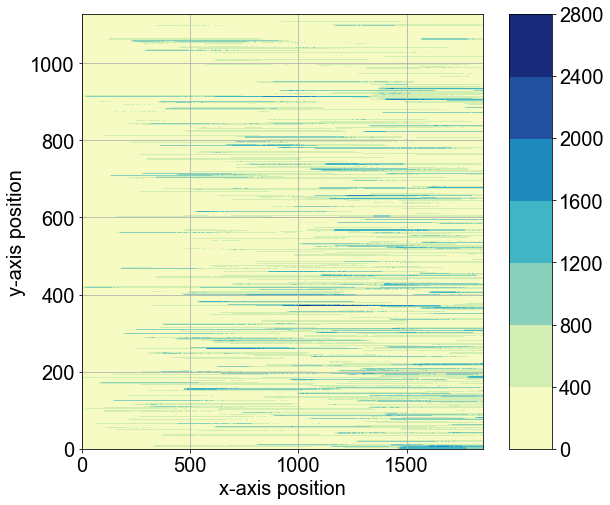

In [126]:
pt.plotContour(u_pix_arr, ss.addNoise(flux_LSF_PSF_matrix2D, u_pix_arr))

#### 4. Estimating forground stars

Forground population of stars in sample (H-K_s < 1.1): 415 stars


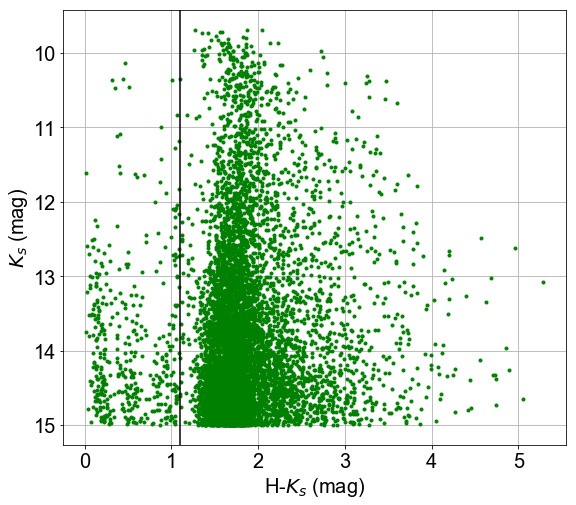

In [43]:
pt.plotMagDiffs(mag_H, mag_Ks, forground_star_cut, len(mag_H))    

### 5. Fleasibility study for the entire central region

#### 5.1 Studying the number of foreground vs GC stars in the whole FOV

In [45]:
x_all, y_all, mag_H_all, mag_Ks_all = fl.selectionCuts(x_pos_full, y_pos_full, \
                                                       mag_H_full, mag_Ks_full,\
                                                       cut_off_ll, pixel_factor)

# dividing the entire central file into ~1.2'sq sections and cal foreground/gc stars
foreground_stars, gc_stars, steps = fl.createGrid(x_all, y_all, mag_H_all,\
                                                  mag_Ks_all, u_pix)

Selecting real stars...
Discarding stars with magnitude > 15.
Discarding all stars withing the NSC...


Plotting the foreground vs GC distribution of stars as a function of the divided grid

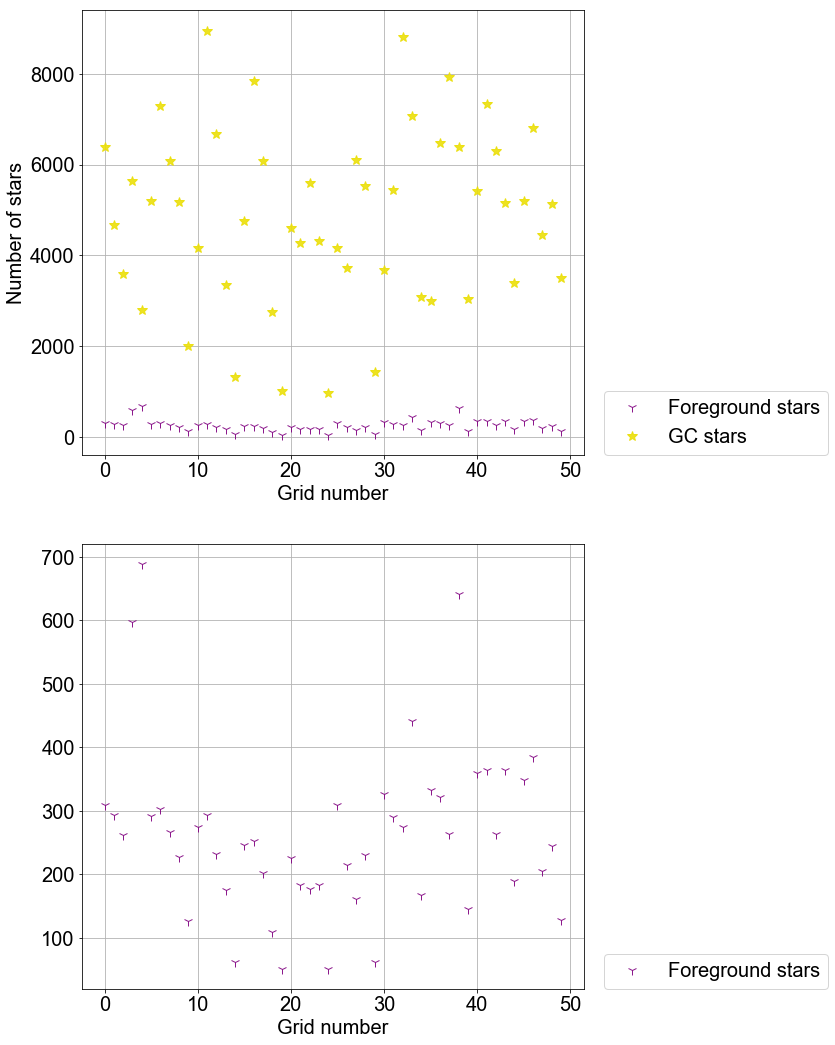

In [46]:
pt.plotForegroundGCstars(foreground_stars, gc_stars)

Plot showing the total volume of stars with their varying brightness.

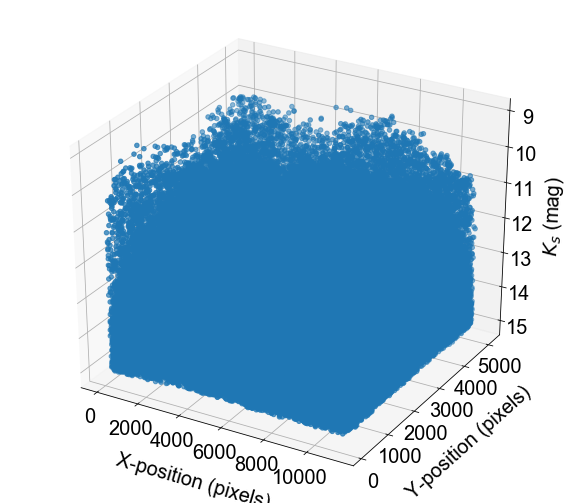

In [47]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

# reshape x,y and mag array for plotting the 3D scatter plot
ll, ul = fl.printDivisors(len(x_all)) 
X, Y, Z = x_all.reshape(ll, ul), y_all.reshape(ll, ul), mag_Ks_all.reshape(ll, ul)

ax.scatter(X, Y, Z, cmap='YlGnBu')
ax.set_xlabel('\n\nX-position (pixels)')
ax.set_ylabel('\n\nY-position (pixels)')
ax.set_zlabel('\n'+r'$K_s$ (mag)')
ax.invert_zaxis()

#### 5.2 Studying the number of permutations of stars-templates required for different values of hot-stellar populations

In [48]:
importlib.reload(ssfm)
importlib.reload(fl)
type_id_arr, num_perms = [], []

for hot_stars in hot_stars_arr:
    print('%.2f percent hot stars: '%(hot_stars*100))
    total_stars = 14+1
    type_id_arr, num_perms = fl.calPermutations(hot_stars, total_stars, \
                                                type_id_arr, num_perms)

1.00 percent hot stars: 
0 stars at Teff = 12000 K, log g = 6.0
0 stars at Teff = 11800 K, log g = 2.5
0 stars at Teff = 10000 K, log g = 3.0
0 stars at Teff = 8400 K, log g = 6.0
0 stars at Teff = 7600 K, log g = 3.5
0 stars at Teff = 6900 K, log g = 3.0
0 stars at Teff = 5900 K, log g = 3.0
15 stars at Teff = 5100 K, log g = 2.0
0 stars at Teff = 4700 K, log g = 1.5
0 stars at Teff = 3900 K, log g = 6.0
---------------------------------

11.00 percent hot stars: 
1 stars at Teff = 12000 K, log g = 6.0
0 stars at Teff = 11800 K, log g = 2.5
0 stars at Teff = 10000 K, log g = 3.0
0 stars at Teff = 8400 K, log g = 6.0
0 stars at Teff = 7600 K, log g = 3.5
0 stars at Teff = 6900 K, log g = 3.0
0 stars at Teff = 5900 K, log g = 3.0
14 stars at Teff = 5100 K, log g = 2.0
0 stars at Teff = 4700 K, log g = 1.5
0 stars at Teff = 3900 K, log g = 6.0
---------------------------------

21.00 percent hot stars: 
3 stars at Teff = 12000 K, log g = 6.0
0 stars at Teff = 11800 K, log g = 2.5
0 stars

#### 5.2 Studying the number of permutations required to generate a template library for a typical 1.2 sq. arcmin region containing ~500 stars.

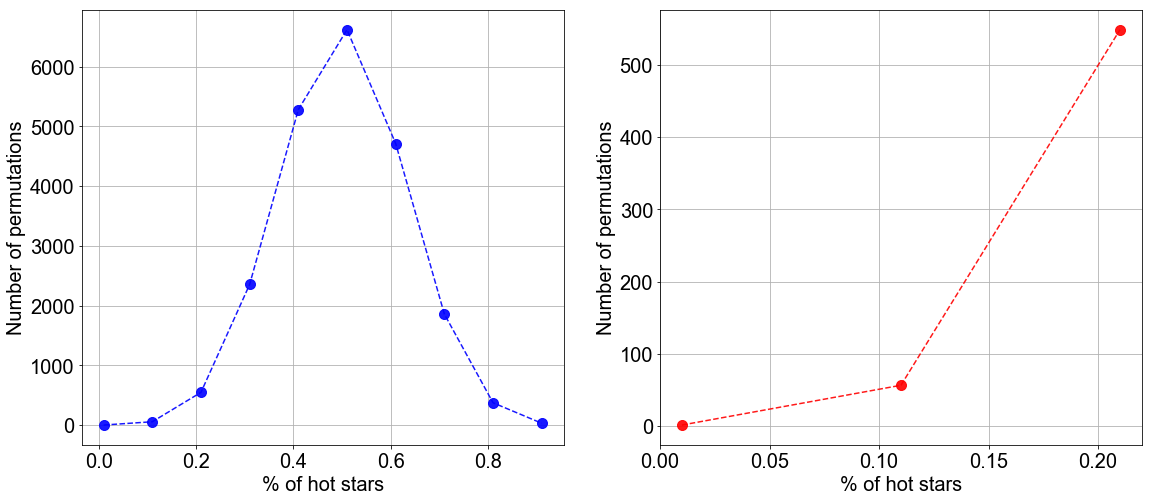

In [49]:
fig, ax = plt.subplots(1,2,figsize=(19,8))

ax[0].plot(hot_stars_arr, num_perms,'--', color= 'b', alpha=0.9, marker="o", markersize=10)
pt.setLabel(ax[0], '% of hot stars', 'Number of permutations', '', 'default', 'default', legend=False)
 
ax[1].plot(hot_stars_arr[0:3], num_perms[0:3],'--', color= 'r', alpha=0.9, marker="o", markersize=10)
pt.setLabel(ax[1], '% of hot stars', 'Number of permutations', '', 'default', 'default', legend=False)
 

The plot above shows that the brute force method of generating all possible permutations of a given stellar configuration works out computationally expensive and is not a fleasible technique to disentangle information from a given slitless image.

In [ ]:
np.save('Data/selected_central_pixels.npy', [x_all, y_all, mag_H_all, mag_Ks_all])